<center><h1><b>LET'S FIND $D^0$ DECAYS</b></h1></center>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import awkward as ak
import uproot

from itertools import combinations
import os

---

# ACCESSING DATA

In [2]:
! ls /mnt/SingleTrackTrees/Data/alice_data_2023_LHC23f_535087_apass4_1300_Thinner/Output/Run535087

Chunk0950  Chunk1020  Chunk1050  Chunk1120  Chunk1150  Chunk1220
Chunk1000  Chunk1030  Chunk1100  Chunk1130  Chunk1200  Chunk1300
Chunk1010  Chunk1040  Chunk1110  Chunk1140  Chunk1210


In [3]:
! ls -lh /mnt/SingleTrackTrees/Data/alice_data_2023_LHC23f_535087_apass4_1300_Thinner/Output/Run535087/Chunk0950/001_007

total 2.0G
-rw-r--r-- 1 ubuntu ubuntu 2.0G May 21 08:38 AO2Dtree.root
-rw-r--r-- 1 ubuntu ubuntu  18K May 21 08:38 AnalysisResults.root
-rw-r--r-- 1 ubuntu ubuntu  518 May 21 08:38 input_data.txt


For now, we focus on the data of a single chunck of 2GB.

In [4]:
path = "/mnt/SingleTrackTrees/Data/alice_data_2023_LHC23f_535087_apass4_1300_Thinner/Output/Run535087/Chunk0950/001_007/AO2Dtree.root"
file = uproot.open(path)
file.classnames()

{'DF_2298181510431936;1': 'TDirectory',
 'DF_2298181510431936/O2collision_001;1': 'TTree',
 'DF_2298181510431936/O2filtertrack;1': 'TTree',
 'DF_2298181510431936/O2filtertrackextr;1': 'TTree',
 'DF_2298181510502944;1': 'TDirectory',
 'DF_2298181510502944/O2collision_001;1': 'TTree',
 'DF_2298181510502944/O2filtertrack;1': 'TTree',
 'DF_2298181510502944/O2filtertrackextr;1': 'TTree',
 'DF_2298181510571872;1': 'TDirectory',
 'DF_2298181510571872/O2collision_001;1': 'TTree',
 'DF_2298181510571872/O2filtertrack;1': 'TTree',
 'DF_2298181510571872/O2filtertrackextr;1': 'TTree',
 'DF_2298181510572384;1': 'TDirectory',
 'DF_2298181510572384/O2collision_001;1': 'TTree',
 'DF_2298181510572384/O2filtertrack;1': 'TTree',
 'DF_2298181510572384/O2filtertrackextr;1': 'TTree',
 'DF_2298181510642880;1': 'TDirectory',
 'DF_2298181510642880/O2collision_001;1': 'TTree',
 'DF_2298181510642880/O2filtertrack;1': 'TTree',
 'DF_2298181510642880/O2filtertrackextr;1': 'TTree',
 'DF_2298181510718144;1': 'TDirecto

In [5]:
# file["DF_2298181510431936/O2collision_001"].show()

In [6]:
file["DF_2298181510431936/O2filtertrack"].arrays(library="pd")

,fIndexCollisions,fIsInsideBeamPipe,fTrackType,fX,fAlpha,fY,fZ,fSnp,fTgl,fSigned1Pt
0,0,1,1,0.034665,-3.093559,0.027728,0.352128,7.131713e-07,0.086724,-2.122640
1,0,1,1,-0.038039,1.057922,0.028758,0.347082,-5.348148e-07,0.565963,1.860431
2,0,1,1,0.004959,-1.053308,-0.046906,0.348381,-3.636550e-06,0.053010,3.211388
3,0,1,1,-0.037739,1.075205,0.016507,0.352450,2.594715e-08,-0.032695,-1.130452
4,0,1,1,0.040489,-2.265095,-0.006677,0.362991,9.847126e-07,-0.628449,-2.689926
...,...,...,...,...,...,...,...,...,...,...
66821,12541,1,1,0.001614,2.176665,-0.170785,0.111903,2.910637e-06,0.714509,-1.140240
66822,12542,1,1,-0.017821,-0.633107,-0.050015,0.588715,1.021886e-06,0.804855,-1.867598
66823,12542,1,1,0.022968,-1.463877,-0.052201,0.591380,6.491810e-07,0.671859,-1.994020
66824,12543,1,1,-0.023210,-0.312354,-0.026541,-1.899057,-1.161476e-07,0.288048,0.931763


---

## DATA INTO PANDAS DATAFRAME

In [7]:
# # CODE FOR UNIFYING EVERY ROOT FILE

# # let's build each path to every ROOT file:
# base = "/mnt/SingleTrackTrees/Data/alice_data_2023_LHC23f_535087_apass4_1300_Thinner/Output/Run535087"
# mid = ["Chunk0950/001_007", "Chunk1000/001_005", "Chunk1000/006_009", "Chunk1010/001_005", "Chunk1010/006_010"]  # ne mancano...
# final = "AO2Dtree.root"

# paths = []
# for mid_path in mid:
#     unified_path = os.path.join(base, mid_path, final)
#     paths.append( unified_path )
#     print( unified_path )

In [8]:
# CODE FOR UNIFYING DIRECTORIES OF A SINGLE ROOT FILE:

num = 50   # number of directories to unify (otherwise it crashes)

names_track_extr = file.keys(filter_name=r"*O2filtertrackextr")
names_track      = file.keys(filter_name=r"*O2filtertrack")
values_track_extr = pd.concat( [ file[item]\
    .arrays(["fPt","fEta","fCharge","fDcaXY","fNsigmaTPCpi","fNsigmaTPCka","fNsigmaTPCpr","fNsigmaTOFpi",
             "fNsigmaTOFka","fNsigmaTOFpr" 	], library="pd") for item in names_track_extr[0:num] ] )
values_track      = pd.concat( [ file[item]\
    .arrays(["fIndexCollisions", "fAlpha"], library="pd") for item in names_track[0:num] ] )

# Add "fIndexCollisions" and "fAlpha" as a new columns
values_track_extr["fIndexCollisions"] = values_track["fIndexCollisions"]
values_track_extr["fAlpha"] = values_track["fAlpha"]

# Final result
df = values_track_extr
N = len(df)
print('Original data:', N, 'rows')

df

Original data: 3340504 rows


,fPt,fEta,fCharge,fDcaXY,fNsigmaTPCpi,fNsigmaTPCka,fNsigmaTPCpr,fNsigmaTOFpi,fNsigmaTOFka,fNsigmaTOFpr,fIndexCollisions,fAlpha
0,0.471111,0.086615,-1,0.004583,1.296971,-6.567831,-14.216860,5.796030,-34.445034,-77.350662,0,-3.093559
1,0.537510,0.539420,1,0.011716,9.544146,1.979263,-9.118285,47.058315,2.731402,-34.971691,0,1.057922
2,0.311392,0.052986,1,-0.005521,-1.248399,-12.175531,-12.922401,-999.000000,-999.000000,-999.000000,0,-1.053308
3,0.884602,-0.032689,-1,-0.001190,0.343225,-1.040863,-6.603751,-999.000000,-999.000000,-999.000000,0,1.075205
4,0.371757,-0.593066,-1,0.003221,-1.047941,-8.668435,-15.893881,-999.000000,-999.000000,-999.000000,0,-2.265095
...,...,...,...,...,...,...,...,...,...,...,...,...
66667,0.321594,0.475848,1,0.000350,-0.011774,-10.792355,-12.475657,-999.000000,-999.000000,-999.000000,12480,1.608172
66668,0.327152,-0.755947,1,0.000699,-0.663768,-9.620825,-11.889036,-999.000000,-999.000000,-999.000000,12481,-1.016753
66669,0.516289,0.658305,1,0.001712,1.511724,-3.253400,-11.654940,-999.000000,-999.000000,-999.000000,12481,0.225494
66670,3.091420,-0.142991,-1,-0.000194,1.424558,3.854532,4.646348,-999.000000,-999.000000,-999.000000,12481,-1.280684


In [9]:
# # OLD CODE USED TO TAKE DATA FROM A SINGLE DIRECTORY OF A ROOT FILE:

# # all data from the Tree 'O2filtertrackextr' of one directory:
# df = file["DF_2298181510431936/O2filtertrackextr"].arrays(library="pd")

# # adding the column 'fIndexCollisions' from 'O2filtertrack':
# df_track = file["DF_2298181510431936/O2filtertrack"].arrays(["fIndexCollisions"], library="pd")
# df["fIndexCollisions"] = df_track["fIndexCollisions"]

# N = len(df)
# print('Original data:', N, 'rows')

# df

---

## PID
Memo: each row of O2filtertrackextr is a single track (i.e. a single particle).

#### TPC
Filtered for both $pi$ and $Ka$ between -3 and +3 sigma. (could be added a filter for the pions curve in the NsigmaKa plot).

In [10]:
N_before = len(df)
df = df[ 
    ( (df['fNsigmaTPCpi'] > -3) & (df['fNsigmaTPCpi'] < 3) )    # selecting pions
    | # or
    ( (df['fNsigmaTPCka'] > -3) & (df['fNsigmaTPCka'] < 3) )    # selecting kaons
    ]
N_tpc = len(df)
print(f'Rejected data wrt start:  {N-N_tpc} ----->  {(N-N_tpc)/N*100:.3f} %' )

Rejected data wrt start:  148827 ----->  4.455 %


#### TOF
Filtered for both $pi$ and $Ka$ between -3 and +3 sigma. (could be added a filter for the pions curve in the NsigmaKa plot).

Also could be more correct to not exclude TOf values of 999 (meaning the information is missing).

In [11]:
N_before = len(df)
df = df[ 
    ( (df['fNsigmaTOFpi'] > -3) & (df['fNsigmaTOFpi'] < 3) )    # selecting pions
    | # or
    ( (df['fNsigmaTOFka'] > -3) & (df['fNsigmaTOFka'] < 3) )    # selecting kaons
    ]
N_tof = len(df)
print(f'Rejected data wrt before:  {N_before-N_tof} ----->  {(N_before-N_tof)/N_before*100:.3f} %' )
print(f'Rejected data wrt start :  {N-N_tof} ----->  {(N-N_tof)/N*100:.3f} %' )
print(f'Remaining data:            {N_tof}')

Rejected data wrt before:  2258285 ----->  70.755 %
Rejected data wrt start :  2407112 ----->  72.058 %
Remaining data:            933392


---

## SINGLE TRACK VARIABLES

#### dcaXY
for the background should be around 0, for the signal different from 0.

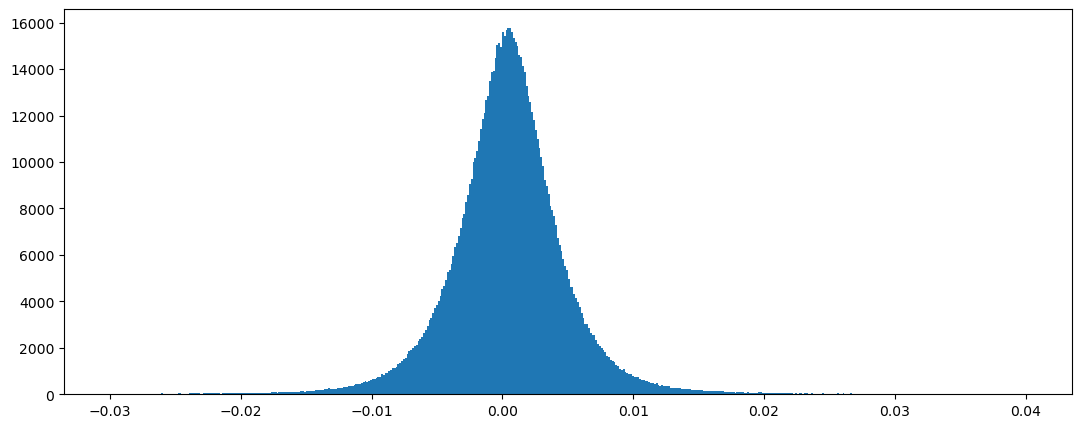

In [12]:
dca_xy = np.array( df['fDcaXY'] )

# filter:
dca_xy_filt = dca_xy[(dca_xy > -0.03) & (dca_xy < 0.04)]
fig,ax = plt.subplots(figsize=(13,5))
ax.hist(dca_xy_filt, bins=500)
plt.show()

I don't see a clear cluster outside the one in the center. Let's try by heart, taking the tails:

In [13]:
N_before = len(df)
df = df[ ( (df['fDcaXY'] > 0.01) | (df['fDcaXY'] < -0.01) ) ]
N_dca = len(df)
print(f'Rejected data wrt before:  {N_before-N_dca} ----->  {(N_before-N_dca)/N_before*100:.3f} %' )
print(f'Rejected data wrt start :  {N-N_dca} ----->  {(N-N_dca)/N*100:.3f} %' )
print(f'Remaining data:            {N_dca}')

Rejected data wrt before:  879425 ----->  94.218 %
Rejected data wrt start :  3286537 ----->  98.384 %
Remaining data:            53967


#### $p_t$

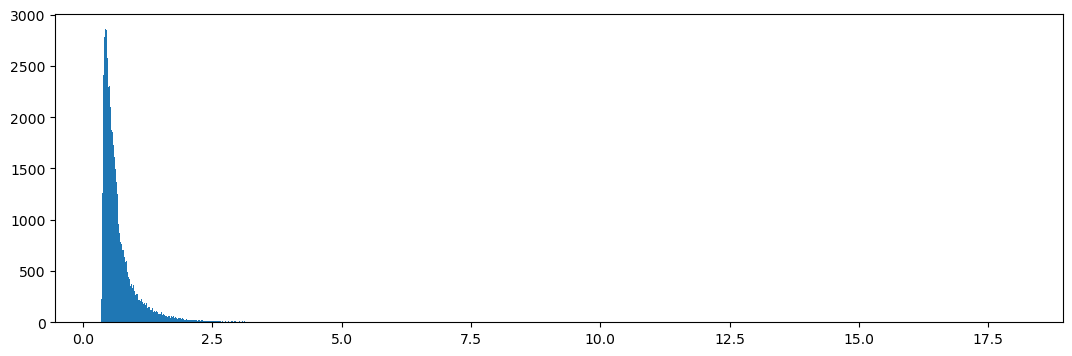

In [14]:
pt = np.array( df['fPt'] )

# plot
fig,ax = plt.subplots(figsize=(13,4))
ax.hist(pt, bins=1000)
plt.show()

As for suggestion, we set $p_t > 0.3$ $GeV/c$.

In [15]:
pt_filt = pt[ pt>0.3 ]

N_before = len(df)
df = df[ df['fPt'] > 0.3 ]
N_pt = len(df)
print(f'Rejected data wrt before:  {N_before-N_pt} ----->  {(N_before-N_pt)/N_before*100:.3f} %' )
print(f'Rejected data wrt start :  {N-N_pt} ----->  {(N-N_pt)/N*100:.3f} %' )
print(f'Remaining data:            {N_pt}')

Rejected data wrt before:  0 ----->  0.000 %
Rejected data wrt start :  3286537 ----->  98.384 %
Remaining data:            53967


It was already filtered for this? I don't remember (check later)

---

## PAIR VARIABLES
Let's search for couples of particles coming from the same collision (through "fIndexCollisions"), with opposite charge (such as $K^-$ and $\pi^+$), and plot their $dcaXY \cdot dcaXY$ distribution.

We do creating a new dataframe where we save the index of each particle in the pair (in this way we have a connection with the original dataframe) and the product of dcaXY of the two particles.

#### INVARIANT MASS
Approximation formula for invariant mass:
$$ M = \sqrt{ 2 \cdot p_{T_1} \cdot p_{T_2} \cdot \left( cosh(\eta_1 - \eta_2) - cos(\phi_1 - \phi_2) \right) } $$

In [ ]:
# let's RESET the indexes of df:
df = df.reset_index(drop=True)

In [35]:
# Particle masses in GeV
m_K = 0.493677
m_pi = 0.139570
m_d0 = 1.86484

In [24]:
# let's initialize a list, then we will create a dataframe
pairs = []

# Iterate over each collision group
for collision_idx, group in df.groupby('fIndexCollisions'):

    # Only collisions with at least 2 tracks
    if len(group) < 2: continue

    # Reset index to get positional 0..N-1 and keep original index in 'orig_index'
    group = group.reset_index().rename(columns={'index': 'orig_index'})

    # Iterate over all unique pairs of tracks
    for i1, i2 in combinations(range(len(group)), 2):
        row1 = group.iloc[i1]
        row2 = group.iloc[i2]

        # only pairs with opposite charge
        if row1['fCharge'] * row2['fCharge'] < 0:
            product_dcaXY = row1['fDcaXY'] * row2['fDcaXY']

            if row1['fCharge'] > 0: pos, neg = row1, row2
            else:                   pos, neg = row2, row1
            
            # INVARIANT MASS calculation
            pt1, pt2 = pos['fPt'], neg['fPt']
            eta1, eta2 = pos['fEta'], neg['fEta']
            phi1, phi2 = pos['fAlpha'], neg['fAlpha']
            delta_eta = eta1 - eta2
            delta_phi = phi1 - phi2

            inv_mass = np.sqrt(2 * pt1 * pt2 * (np.cosh(delta_eta) - np.cos(delta_phi)))

            pairs.append({
                'collision_index': collision_idx,
                'track1_index': int(row1['orig_index']),
                'track2_index': int(row2['orig_index']),
                'dcaXY_product': product_dcaXY,
                'inv_mass': inv_mass
            })


# create a dataframe with the result:
df_pairs = pd.DataFrame(pairs)

#### DcaXY product PLOT

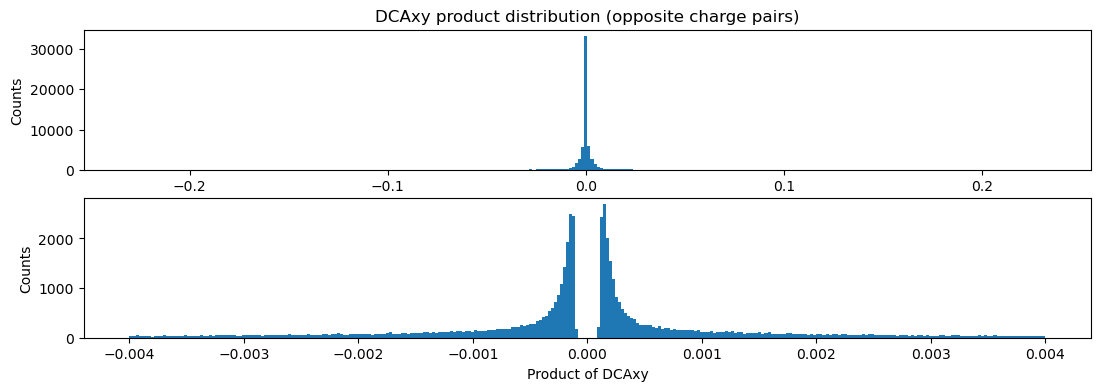

In [25]:
# Plot histogram
fig,ax = plt.subplots(2,1,figsize=(13,4))
ax[0].hist(df_pairs['dcaXY_product'], bins=300)
ax[0].set_ylabel("Counts")
ax[0].set_title("DCAxy product distribution (opposite charge pairs)")
# filter plot:
prod = df_pairs['dcaXY_product']
prod_filt = prod[ (prod>-0.004) & (prod<0.004) ]
ax[1].hist(prod_filt, bins=300)
ax[1].set_ylabel("Counts")
ax[1].set_xlabel("Product of DCAxy")


plt.show()

#### INAVARIANT MASS PLOT

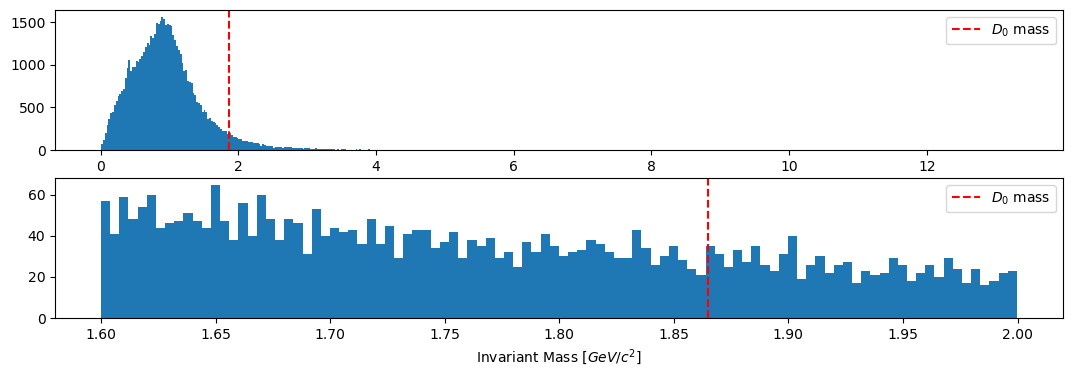

In [45]:
fig,ax = plt.subplots(2,1,figsize=(13,4))

# plot: 
val = df_pairs["inv_mass"]
ax[0].hist( val, bins=500 )
ax[0].axvline(x=m_d0, color='red', linestyle='--', linewidth=1.5, label=f'$D_0$ mass')
ax[0].legend()

# zoom plot:
val = val[ (val>1.6) & (val<2) ]
ax[1].hist( val, bins=100 )
ax[1].axvline(x=m_d0, color='red', linestyle='--', linewidth=1.5, label=f'$D_0$ mass')
ax[1].legend()
ax[1].set_xlabel(f"Invariant Mass [$GeV/c^2$]")
plt.show()